# **Importing Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import random
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input, decode_predictions, ResNet50
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
import seaborn as sns

2024-04-10 13:42:23.661151: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 13:42:23.661313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 13:42:23.837017: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Getting the Data**

In [3]:
pwd

'/kaggle/working'

In [4]:
my_data_dir='/kaggle/working/path/to/your'

# **Train Test Split**

In [5]:
import os
import shutil
import random

# Veri setinin bulunduğu dizin
data_dir = "/kaggle/input/flowers-recognition/flowers"

# Train ve test dizinlerini oluştur
train_dir = "path/to/your/train_data"
test_dir = "path/to/your/test_data"
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Veri setindeki sınıflar
classes = os.listdir(data_dir)

# Train ve test oranı
train_ratio = 0.80

# Her sınıf için veri setini train ve test olarak ayır
for cls in classes:
    class_dir = os.path.join(data_dir, cls)
    images = os.listdir(class_dir)
    random.shuffle(images)
    train_size = int(len(images) * train_ratio)
    train_images = images[:train_size]
    test_images = images[train_size:]

    # Train ve test görüntülerini kopyala
    for img in train_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(train_dir, cls, img)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for img in test_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(test_dir, cls, img)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

print("Train-test split completed successfully.")


Train-test split completed successfully.


In [6]:
os.listdir(my_data_dir)

['train_data', 'test_data']

In [7]:
train_path = my_data_dir+'/train_data'
test_path = my_data_dir+'/test_data'

In [8]:
os.listdir(train_path)

['sunflower', 'rose', 'dandelion', 'tulip', 'daisy']

In [9]:
len(os.listdir(train_path+'/rose'))

627

In [10]:
len(os.listdir(train_path+'/tulip'))

787

In [11]:
os.listdir(train_path+'/rose')[:10]

['18990187093_09f2bff8fc_m.jpg',
 '145862135_ab710de93c_n.jpg',
 '15333843782_060cef3030.jpg',
 '7461897646_3203dbe067_n.jpg',
 '18464075576_4e496e7d42_n.jpg',
 '13264214185_d6aa79b3bd.jpg',
 '5336562212_d014ddf9ca_n.jpg',
 '5799616059_0ffda02e54.jpg',
 '4231745228_ece86330d9.jpg',
 '159079265_d77a9ac920_n.jpg']

In [12]:
os.listdir(train_path+'/tulip')[:10]

['5717950291_af2aed83d8_n.jpg',
 '17734051745_9382a7bcba_n.jpg',
 '4562423077_00b16240dc_n.jpg',
 '14674067742_73c2602aa6_m.jpg',
 '19884050362_347e5342f2_n.jpg',
 '9019694597_2d3bbedb17.jpg',
 '2087981909_fd468de5c4_n.jpg',
 '14122029097_3e3285ca5c_n.jpg',
 '3516269489_cef36e87a6.jpg',
 '8695367666_0809529eaf_n.jpg']

In [13]:
path1=train_path+'/rose'+'/5349250331_05501d6557_n.jpg'
path2=train_path+'/tulip'+'/5717950291_af2aed83d8_n.jpg'

In [14]:
rose_img=imread(path1)
tulip_img=imread(path2)

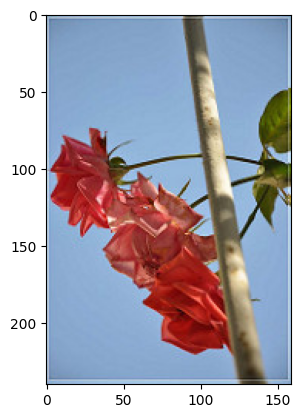

In [15]:
plt.imshow(rose_img);

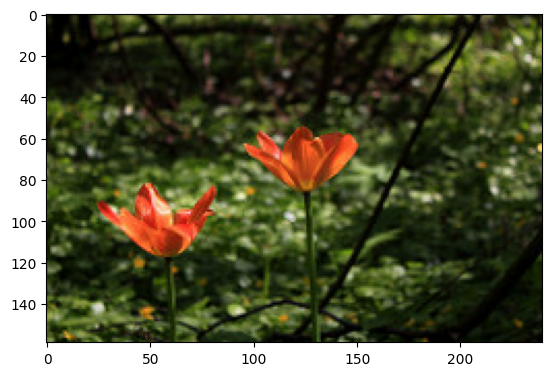

In [16]:
plt.imshow(tulip_img);

# **Data Augmentation**

In [17]:
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split = 0.3,
    rescale = 1/255
)

In [18]:
batch_size = 32
img_height = 256
img_width = 256

In [19]:
training_data = image_gen.flow_from_directory(
    train_dir,
    subset = "training",
    class_mode="categorical",
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False
)

validation_data = image_gen.flow_from_directory(
    train_dir,
    subset = "validation",
    class_mode="categorical",
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False
)

Found 2418 images belonging to 5 classes.
Found 1034 images belonging to 5 classes.


In [20]:
image_shape = (256,256,3)

# **CNN Model**

In [ ]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
          
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)

In [ ]:
results = model.fit(training_data,epochs=50,
                    validation_data=validation_data,
                    callbacks=[early_stop])

In [ ]:
summary = pd.DataFrame(model.history.history)
summary.head(15)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [ ]:
model.evaluate(training_data)

In [ ]:
model.evaluate(validation_data)

In [ ]:
pred_probabilities = model.predict(validation_data)
pred_probabilities

In [ ]:
validation_data.classes[:50]

In [ ]:
predictions = pred_probabilities > 0.5

In [ ]:
predictions = pred_probabilities > 0.5

In [ ]:
#print(classification_report(validation_data.classes,predictions))

# **ConvNeXtTiny**

In [ ]:
convex_model = Sequential()

pretrained_model= tf.keras.applications.ConvNeXtTiny(include_top=False,
                   input_shape=image_shape,
                   pooling='avg',
                   weights= 'imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

convex_model.add(pretrained_model)
convex_model.add(Flatten())
convex_model.add(Dense(512, activation='relu'))
convex_model.add(Dense(5, activation='softmax'))
convex_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

convex_model.summary()

In [ ]:
results = convex_model.fit(training_data,epochs=5,
                    validation_data=validation_data,
                    callbacks=[early_stop])

In [ ]:
summary = pd.DataFrame(convex_model.history.history)
summary.head(15)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [ ]:
convex_model.evaluate(training_data)
convex_model.evaluate(validation_data)

In [ ]:
pred_probabilities = convex_model.predict(validation_data)
pred_probabilities

In [ ]:
validation_data.classes[:50]

In [ ]:
predictions = pred_probabilities > 0.5

In [ ]:
validation_data.classes

In [ ]:
print(classification_report(validation_data.classes,predictions))

# **Xception Model**

In [ ]:
xception_model = Sequential()

pretrained_model= tf.keras.applications.Xception(include_top=False,
                   input_shape=image_shape,
                   pooling='avg',
                   weights= 'imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

xception_model.add(pretrained_model)
xception_model.add(Flatten())
xception_model.add(Dense(512, activation='relu'))
xception_model.add(Dense(5, activation='softmax'))
xception_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

xception_model.summary()

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)

In [ ]:
results = xception_model.fit(training_data,epochs=20,
                    validation_data=validation_data,
                    callbacks=[early_stop])

In [ ]:
summary = pd.DataFrame(xception_model.history.history)
summary.head(15)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [ ]:
xception_model.evaluate(training_data)

In [ ]:
xception_model.evaluate(validation_data)

In [ ]:
pred_probabilities = xception_model.predict(validation_data)
pred_probabilities

In [ ]:
validation_data.classes[:50]

In [ ]:
predictions = pred_probabilities > 0.5

In [ ]:
from sklearn.metrics import classification_report
#print(classification_report(validation_data.classes,predictions))

# **VCG16 Model**

In [ ]:
vcg16_model = Sequential()

pretrained_model= tf.keras.applications.VGG16(include_top=False,
                   input_shape=image_shape,
                   pooling='avg',
                   weights= 'imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

vcg16_model.add(pretrained_model)
vcg16_model.add(Flatten())
vcg16_model.add(Dense(512, activation='relu'))
vcg16_model.add(Dense(5, activation='softmax'))
vcg16_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

vcg16_model.summary()

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)

In [ ]:
results = vcg16_model.fit(training_data,epochs=20,
                    validation_data=validation_data,
                    callbacks=[early_stop])

In [ ]:
summary = pd.DataFrame(vcg16_model.history.history)
summary.head(15)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [ ]:
vcg16_model.evaluate(training_data)
vcg16_model.evaluate(validation_data)

In [ ]:
pred_probabilities = vcg16_model.predict(validation_data)
pred_probabilities

In [ ]:
validation_data.classes[:50]

In [ ]:
predictions = pred_probabilities > 0.5

In [ ]:
validation_data.classes

In [ ]:
print(classification_report(validation_data.classes,predictions))

# **MobileNetV2 Model**

In [ ]:
mobilenet_model = Sequential()

pretrained_model= tf.keras.applications.MobileNetV2(include_top=False,
                   input_shape=image_shape,
                   pooling='avg',
                   weights= 'imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobilenet_model.add(pretrained_model)
mobilenet_model.add(Flatten())
mobilenet_model.add(Dense(512, activation='relu'))
mobilenet_model.add(Dense(5, activation='softmax'))
mobilenet_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

mobilenet_model.summary()

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)

In [ ]:
results = mobilenet_model.fit(training_data,epochs=20,
                    validation_data=validation_data,
                    callbacks=[early_stop])

In [ ]:
summary = pd.DataFrame(mobilenet_model.history.history)
summary.head(15)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [ ]:
mobilenet_model.evaluate(training_data)

In [ ]:
mobilenet_model.evaluate(validation_data)

In [ ]:
pred_probabilities = mobilenet_model.predict(validation_data)
pred_probabilities

In [ ]:
validation_data.classes[:50]

In [ ]:
predictions = pred_probabilities > 0.5

In [ ]:
validation_data.classes

In [ ]:
print(classification_report(validation_data.classes,predictions))

# **ResNet152**

In [ ]:
resnet_model152 = Sequential()

pretrained_model= tf.keras.applications.ResNet152(include_top=False,
                   input_shape=image_shape,
                   pooling='avg',
                   weights= 'imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model152.add(pretrained_model)
resnet_model152.add(Flatten())
resnet_model152.add(Dense(512, activation='relu'))
resnet_model152.add(Dense(5, activation='softmax'))
resnet_model152.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

resnet_model152.summary()

In [ ]:
results = resnet_model152.fit(training_data,epochs=15,
                    validation_data=validation_data,
                    callbacks=[early_stop])

In [ ]:
summary = pd.DataFrame(resnet_model152.history.history)
summary.head()

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [ ]:
resnet_model152.evaluate(training_data)
resnet_model152.evaluate(validation_data)


In [ ]:
pred_probabilities = resnet_model152.predict(validation_data)
pred_probabilities

In [ ]:
validation_data.classes[:50]

In [ ]:
predictions = pred_probabilities > 0.5

In [ ]:
validation_data.classes

In [ ]:
print(classification_report(validation_data.classes,predictions))